# Santander Value Prediction Challenge
Predict the value of transactions for potential customers.

The dataset originally came from here: 
https://www.kaggle.com/c/santander-value-prediction-challenge
    
    
According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.


## 1. Libraries


In [24]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb


ImportError: No module named lightgbm

## 2. Load Data


In [25]:
train_df = pd.read_csv('train.csv')
display(train_df.head(n = 5))

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [26]:
test_df = pd.read_csv('test.csv')
display(test_df.head(n = 5))

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Explore Data


In [5]:
print ("Train rows and columns : ", train_df.shape)
print ("Test rows and columns : ", test_df.shape)

('Train rows and columns : ', (4459, 4993))
('Test rows and columns : ', (49342, 4992))


Observations:

- Test set is almost 10 times as that of train set.
- Public LB uses 49% of the test set for evaluation. So may be it is better to give some (if not more) weightage to LB scores.
- Number of columns is more than the number of train rows. So need to be careful with feature selection / engineering

In [6]:
display(train_df.head(n = 5))

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Observations:

- The column names are anonymized and so we do not know what they mean
- There are many zero values present in the data
- From this discussion post, the dataset is a sparse tabular one.

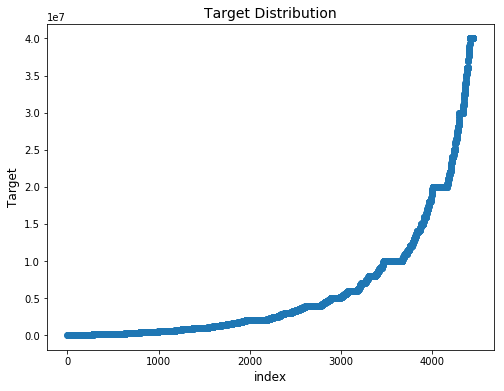

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()


Looks like there are not any visible outliers in the data but the range is quite high.

We can now do a histogram plot of the target variable.

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

NameError: name 'sns' is not defined

This is a right (Thanks to Wesam for pointing out my mistake) skewed distribution with majority of the data points having low value. Our competition admins are aware of this one and so they have chosen the evaluation metric as RMSLE (Root Mean Squared Logarithmic Error.).

So let us do a histogram plot on the log of target variables and recheck again.

In [9]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train_df["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

NameError: name 'sns' is not defined

This looks much better than the old one.

Missing values:

Now let us check if there are missing values in the dataset.

In [10]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


There are no missing values in the dataset :)

Now let us also check the data type of the columns.

In [11]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


Majority of the columns are of integer type and the rest are float type. There is only one string column which is nothing but 'ID' column.

In [12]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

In [13]:
str(constant_df.col_name.tolist())

"['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a742107', '08b9ec4ae', 'd95203ded

Correlation of features with target:

Now let us find the correlation of the variables with target and plot them.

Thanks to @Heads or Tails kernel and Tariq's comment, it might be a good idea to use Spearman correlation inplace of pearson since spearman is computed on ranks and so depicts monotonic relationships while pearson is on true values and depicts linear relationships.

There are thousands of variables and so plotting all of them will give us a cluttered plot. So let us take only those variables whose absolute spearman correlation coefficient is more than 0.1 (just to reduce the number of variables) and plot them.

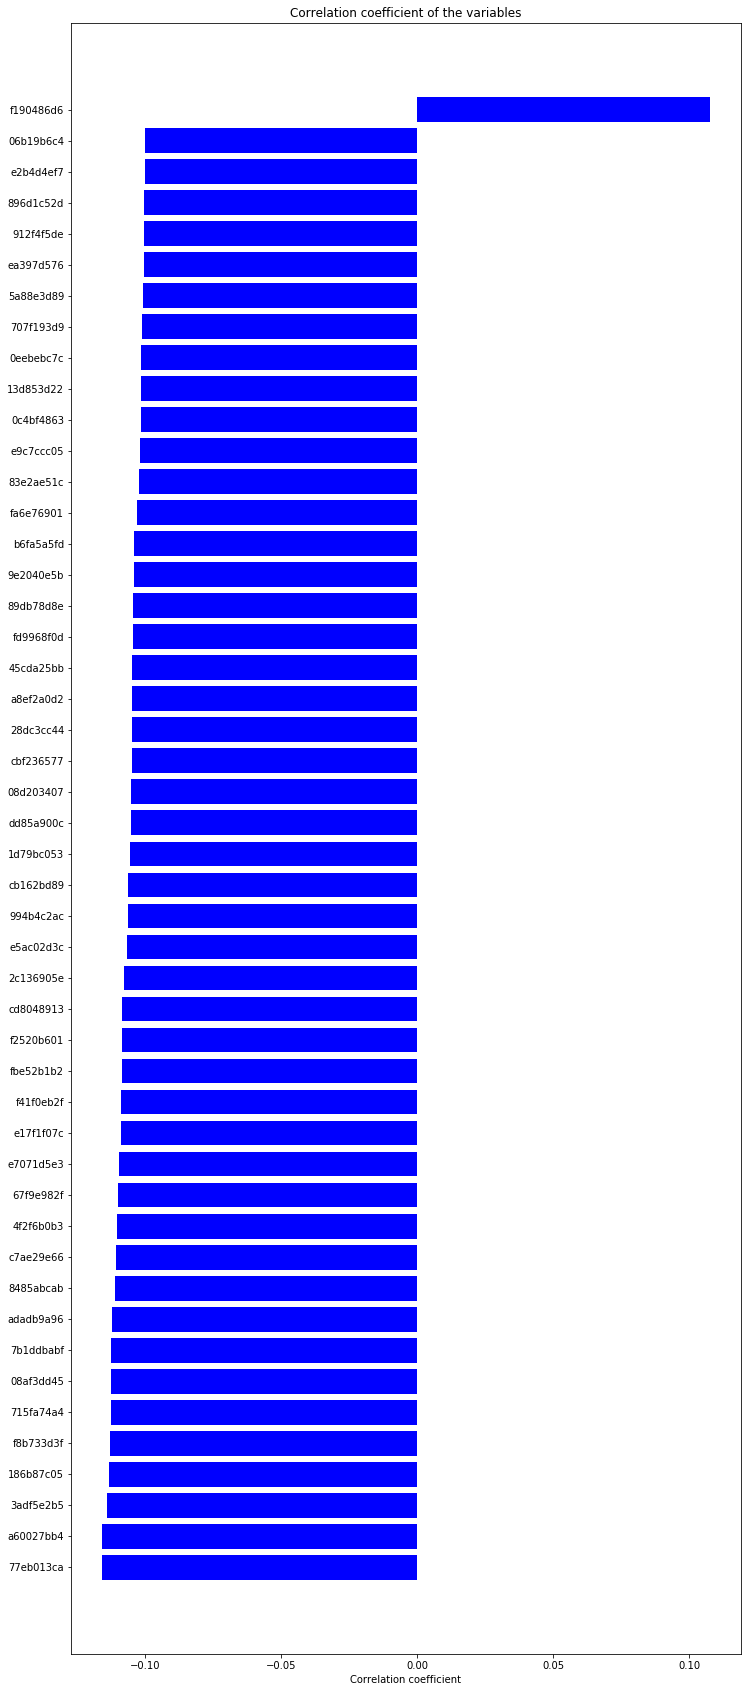

In [14]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

There are quite a few variables with absolute correlation greater than 0.1

Correlation Heat Map:

Now let us take these variables whose absolute value of correlation with the target is greater than 0.11 (just to reduce the number of features fuether) and do a correlation heat map.

This is just done to identify if there are any strong monotonic relationships between these important features. If the values are high, then probably we can choose to keep one of those variables in the model building process. Please note that we are doing this only for the very few features and feel free to add more features to explore more.

NameError: name 'sns' is not defined

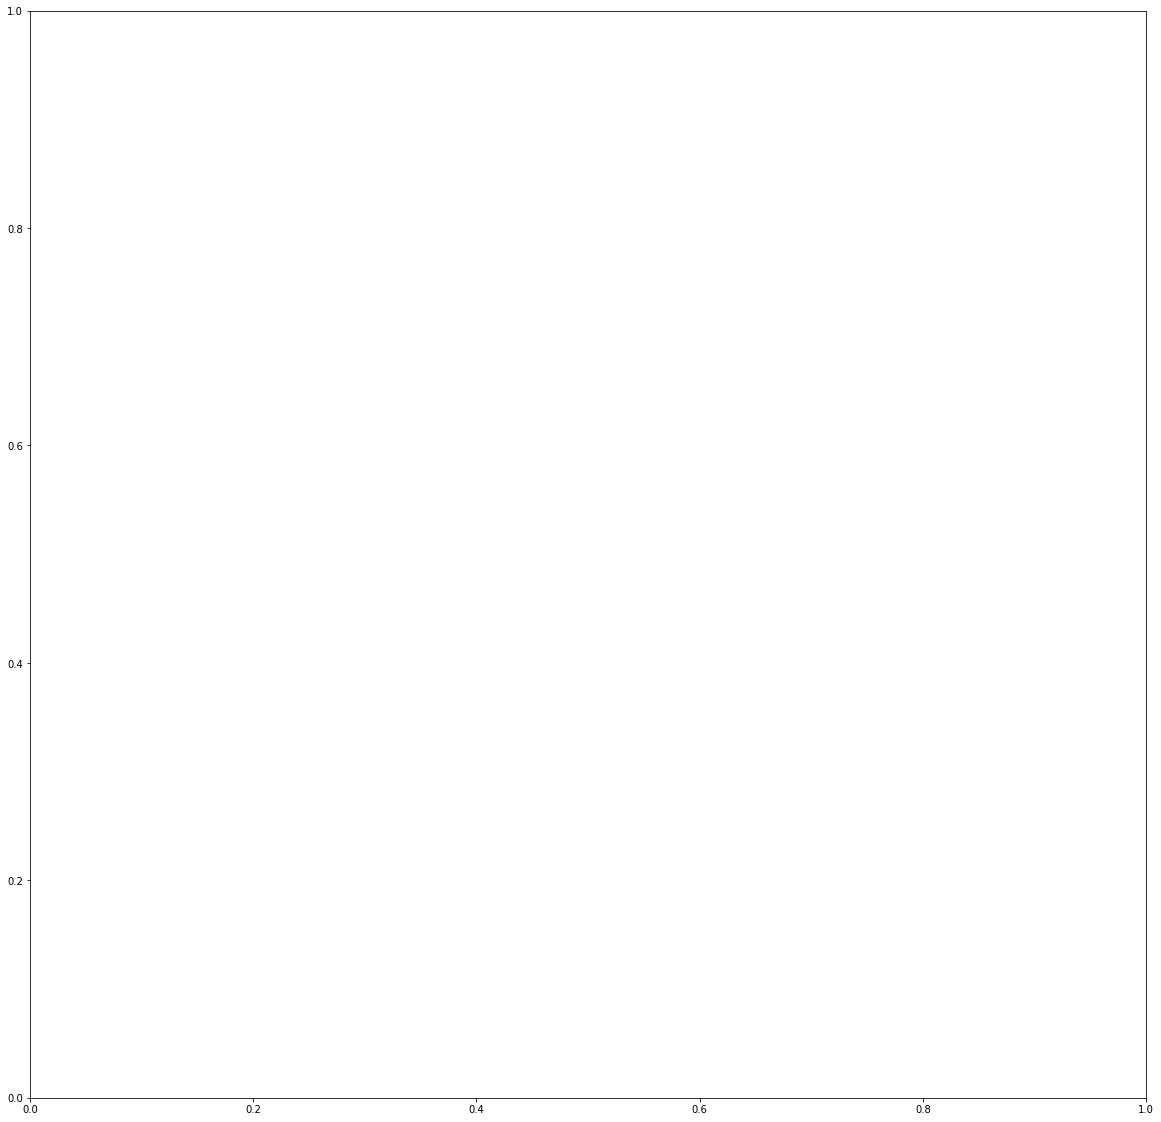

In [15]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

Seems like none of the selected variables have spearman correlation more than 0.7 with each other.

The above plots helped us in identifying the important individual variables which are correlated with target. However we generally build many non-linear models in Kaggle competitions. So let us build some non-linear models and get variable importance from them.

In this notebook, we will build two models to get the feature importances - Extra trees and Light GBM. It could also help us to see if the important features coming out from both of them are consistent. Let us first start with ET model.

Feature Importance - Extra trees model

Our Evaluation metric for the competition is RMSLE. So let us use log of the target variable to build our models. Also please note that we are removing those variables with constant values (that we identified earlier).

In [16]:
### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

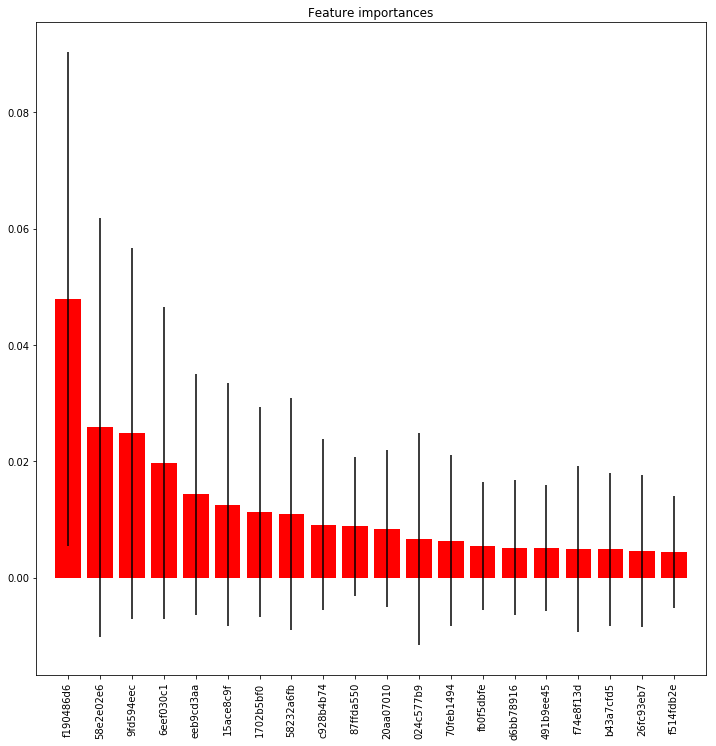

In [17]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

'f190486d6' seems to be the important variable followed by '58e2e02e6'.

Feature Importance & Baseline - Light GBM:

Now let us build a Light GBM model to get the feature importance.

Apart from feature importance, let us also get predictions on the test set using this model and keep them as baseline predictions.

Below code is a custom helper function for Light GBM.

In [18]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

Let us do KFold cross validation and average the predictions of the test set.

In [21]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

NameError: global name 'lgb' is not defined

So the validation set RMSLE of the folds range from 1.40 to 1.46.

Let us write the predictions of the model and write it to a file

In [22]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_lgb.csv", index=False)

This model scored 1.47 RMSLE on the public LB. We did not do any feature selection (apart from removing the constant variables), feature engineering and parameter tuning. So doing that will further imporve the score. We can use this as our baseline model for any further modeling.

Now let us look at the feature importance of this model.

NameError: name 'lgb' is not defined

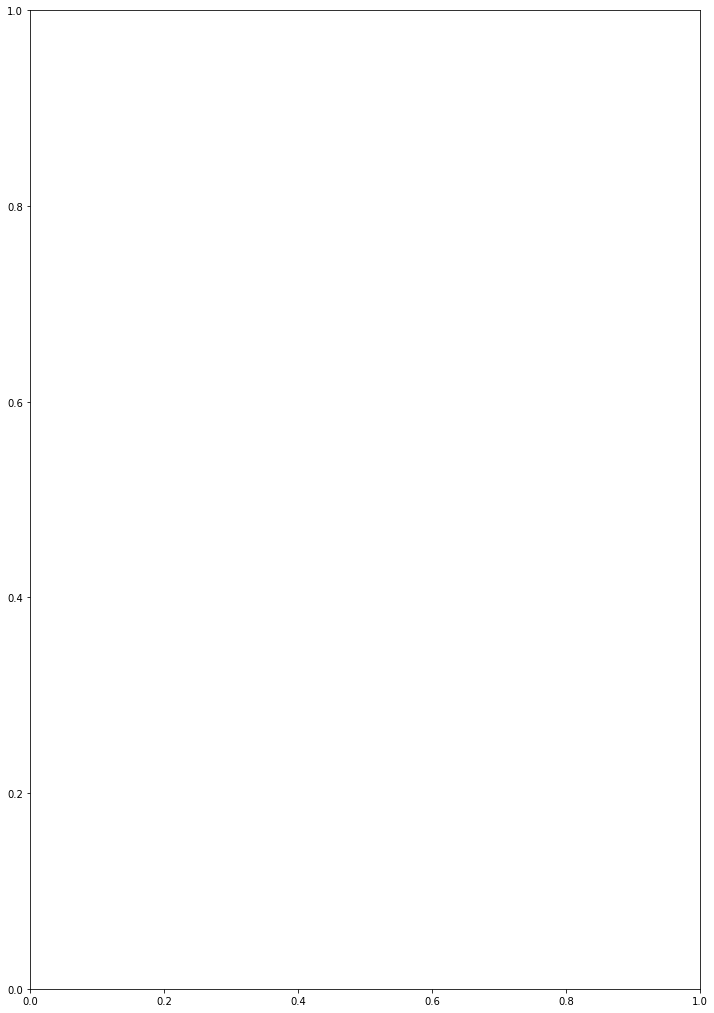

In [23]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

Here again the top two important features are same as that of the Extra trees model.

So we could also do some form of feature selection using these feature importances and improve our models further.

May be in the next versions, let us look at the top variables from the non-linear models and do some more further analysis to understand tham.!

In [28]:
cols = [
    "f190486d6","58e2e02e6","eeb9cd3aa","9fd594eec","6eef030c1","15ace8c9f",
    "fb0f5dbfe","58e056e12","20aa07010","024c577b9","d6bb78916",
    "b43a7cfd5","58232a6fb"
]
rows = np.array([2072,3493,379,2972,2367,4415,2791,3980,194,1190,3517,811,4444])-1

In [30]:
tmp = train_df.loc[rows, ["ID","target"]+cols]
print('original shape', tmp.shape)
tmp

('original shape', (13, 15))


,ID,target,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb
2071,7862786dc,3513333.34,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00,440000.00,3076666.66,550000.00,247166.66,296444.44
3492,c95732596,160000.00,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00,440000.00,3076666.66,550000.00,247166.66
378,16a02e67a,2352551.72,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00,440000.00,3076666.66,550000.00
2971,ad960f947,280000.00,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00,440000.00,3076666.66
2366,8adafbb52,5450500.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00,440000.00
4414,fd0c7cfc2,1359000.00,280000.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00,0.00
2790,a36b78ff7,60000.00,5450500.00,280000.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54,1600000.00
3979,e42aae1b8,12000000.00,1359000.00,5450500.00,280000.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00,466461.54
193,0b132f2c6,500000.00,60000.00,1359000.00,5450500.00,280000.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00,3147200.00
1189,448efbb28,1878571.42,12000000.00,60000.00,1359000.00,5450500.00,280000.00,2352551.72,160000.00,3513333.34,310000.00,0.00,1477600.00,1586888.88,75000.00


## 3. Evaluation Criteria


The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

## 4. Submitting File

In [27]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = np.mean(train_df["target"])
sub_df.to_csv("submission.csv", index=False)